In [1]:

# Check if GPU is available for TensorFlow and PyTorch and perform a simple test

try:
    import tensorflow as tf
    print("TensorFlow Version:", tf.__version__)

    if tf.config.list_physical_devices('GPU'):
        print("GPU is available and detected by TensorFlow")
    else:
        print("GPU not detected. Please check CUDA installation.")

    print("GPUs available for TensorFlow:", tf.config.list_physical_devices('GPU'))
except ImportError:
    print("TensorFlow is not installed.")


TensorFlow Version: 2.17.0
GPU is available and detected by TensorFlow
GPUs available for TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Cell 1: Import Necessary Libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Dropout,  BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, ResNet50
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, ReLU, Input, Add
from tensorflow.keras.models import Model
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz

--2024-11-09 23:50:35--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  35.6MB/s    in 4.9s    

2024-11-09 23:50:40 (33.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [5]:
def load_cifar10_data(path):
    x_train = []
    y_train = []

    try:
        for i in range(1, 6):
            with open(f'{path}/data_batch_{i}', 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                x_train.append(batch['data'])
                y_train.extend(batch['labels'])

        x_train = np.concatenate(x_train)
        x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        y_train = np.array(y_train)

        # Load the test data
        with open(f'{path}/test_batch', 'rb') as file:
            test_batch = pickle.load(file, encoding='latin1')
            x_test = test_batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
            y_test = np.array(test_batch['labels'])

        return (x_train, y_train), (x_test, y_test)
    except FileNotFoundError as e:
        print("File not found. Please ensure CIFAR-10 data is correctly placed.")
        raise e

# Load data
path_to_cifar10 = 'cifar-10-batches-py'
(x_train, y_train), (x_test, y_test) = load_cifar10_data(path_to_cifar10)


In [6]:
x_train, x_test = x_train / 255.0, x_test / 255.0
num_classes = 10
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes), tf.keras.utils.to_categorical(y_test, num_classes)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


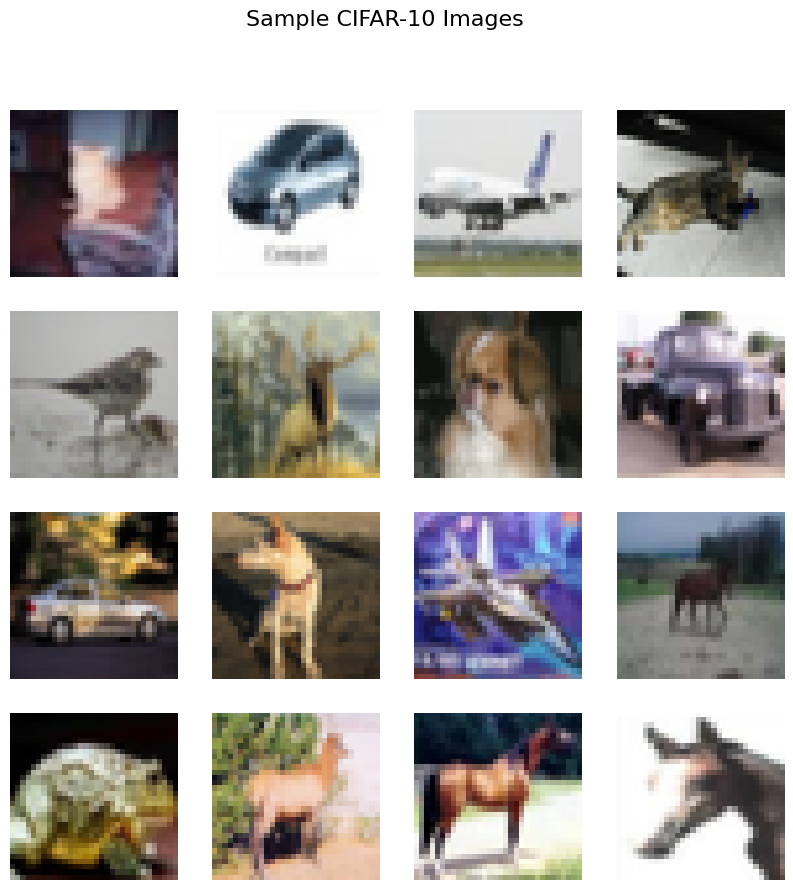

In [7]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.suptitle('Sample CIFAR-10 Images', fontsize=16)
plt.savefig('cifar10_samples.png')
plt.show()
plt.close()

In [8]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)


In [9]:
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
densenet_model = keras.Sequential([
        densenet,
    GlobalAveragePooling2D(),

    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dropout(0.5),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

adam_optimizer = Adam(learning_rate=0.001 )

densenet_model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.5
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks_list = [early_stopping, lr_scheduler]


In [11]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
resnet_model = keras.Sequential([
    resnet,
GlobalAveragePooling2D(),

    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dropout(0.5),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])
adam_optimizer = Adam(learning_rate=0.001 )
resnet_model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
early_stopping_resnet = EarlyStopping(monitor='val_loss', patience=5)
lr_reduction_resnet = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, verbose=1,restore_best_weights=True)
callbacks_resnet = [early_stopping_resnet, lr_reduction_resnet]


In [13]:
history_densenet = densenet_model.fit(
    datagen.flow(x_train, y_train, batch_size=125, ),
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=callbacks_list
)


Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 195s 170ms/step - accuracy: 0.4402 - loss: 1.7217 - val_accuracy: 0.5778 - val_loss: 1.2732 - learning_rate: 0.0010
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 106ms/step - accuracy: 0.7015 - loss: 0.8888 - val_accuracy: 0.7784 - val_loss: 0.6555 - learning_rate: 0.0010
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.7547 - loss: 0.7338 - val_accuracy: 0.7180 - val_loss: 0.8330 - learning_rate: 0.0010
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.7871 - loss: 0.6408 - val_accuracy: 0.6824 - val_loss: 1.4536 - learning_rate: 0.0010
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.7975 - loss: 0.6047 - val_accuracy: 0.7404 - val_loss: 0.7787 - learning_rate: 0.0010
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.7896 - loss: 0.6248 - val_accuracy: 0.6262 - val_loss: 2.7874 - learning_rate: 0.0010
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 44s 116ms/step - accuracy: 0.

In [14]:
test_loss_densenet, test_acc_densenet = densenet_model.evaluate(x_test, y_test)
print(f'DenseNet121 Test accuracy: {test_acc_densenet:.4f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7811 - loss: 0.6570
DenseNet121 Test accuracy: 0.7792


In [15]:
history_resnet = resnet_model.fit(datagen.flow(x_train, y_train, batch_size=125),
                                  epochs=10,
                                  validation_data=(x_val, y_val),
                                  callbacks=callbacks_resnet)


Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 108s 132ms/step - accuracy: 0.3827 - loss: 1.8938 - val_accuracy: 0.1368 - val_loss: 3.5956 - learning_rate: 0.0010
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - accuracy: 0.6432 - loss: 1.0634 - val_accuracy: 0.2700 - val_loss: 2.6790 - learning_rate: 0.0010
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.6897 - loss: 0.9273 - val_accuracy: 0.4946 - val_loss: 1.8179 - learning_rate: 0.0010
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - accuracy: 0.7096 - loss: 0.8712 - val_accuracy: 0.6220 - val_loss: 1.6032 - learning_rate: 0.0010
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.7487 - loss: 0.7601 - val_accuracy: 0.6530 - val_loss: 4.7232 - learning_rate: 0.0010
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - accuracy: 0.7644 - loss: 0.7163 - val_accuracy: 0.6828 - val_loss: 1.0523 - learning_rate: 0.0010
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.

In [16]:
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(x_test, y_test)
print(f'ResNet50 Test accuracy: {test_acc_resnet:.4f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7571 - loss: 0.7313
ResNet50 Test accuracy: 0.7575


In [20]:
def residual_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x
def ResNet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)
num_classes = 10
resnet18_model = ResNet18(input_shape=input_shape, num_classes=num_classes)

adam_optimizer = Adam(learning_rate=0.001)

resnet18_model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
history_resnet18 = resnet18_model.fit(datagen.flow(x_train, y_train, batch_size=125),
                                  epochs=10,
                                  validation_data=(x_val, y_val)
                                  #callbacks=callbacks_resnet
                                    )


Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.8428 - loss: 0.4451 - val_accuracy: 0.7244 - val_loss: 0.9663
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.8465 - loss: 0.4370 - val_accuracy: 0.6800 - val_loss: 1.1465
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.8528 - loss: 0.4165 - val_accuracy: 0.7948 - val_loss: 0.6083
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - accuracy: 0.8479 - loss: 0.4411 - val_accuracy: 0.7266 - val_loss: 0.9668
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - accuracy: 0.8612 - loss: 0.3948 - val_accuracy: 0.7972 - val_loss: 0.5883
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.8672 - loss: 0.3792 - val_accuracy: 0.8020 - val_loss: 0.5892
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.8699 - loss: 0.3697 - val_accuracy: 0.7562 - val_loss: 0.8044
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.8715 - loss: 0.3655 

In [27]:
test_loss_resnet18, test_acc_resnet18 = resnet18_model.evaluate(x_test, y_test)
print(f'ResNet18 Test accuracy: {test_acc_resnet18:.4f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8092 - loss: 0.6041
ResNet18 Test accuracy: 0.8031


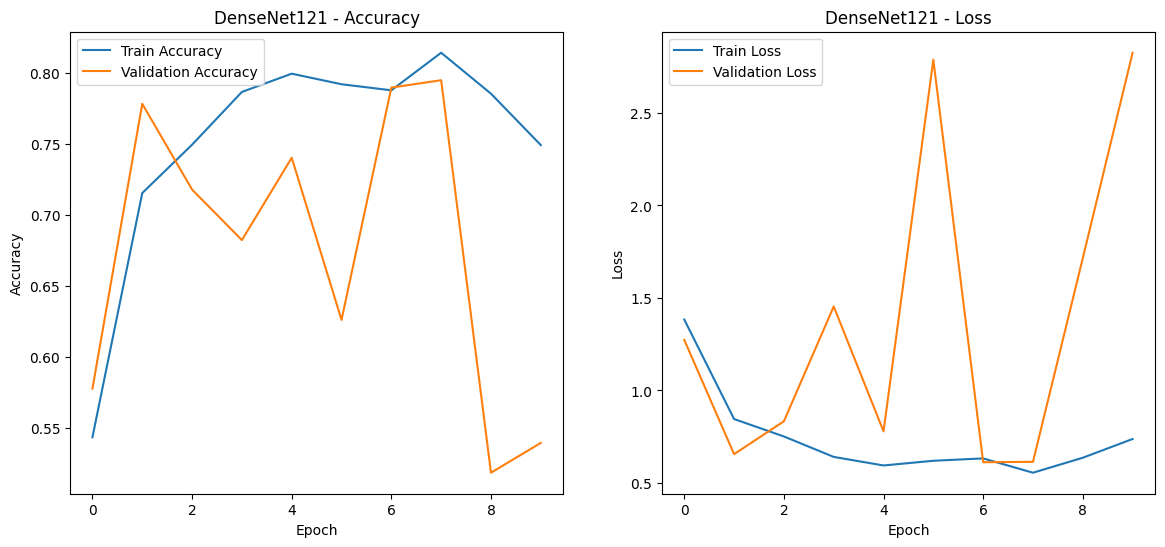

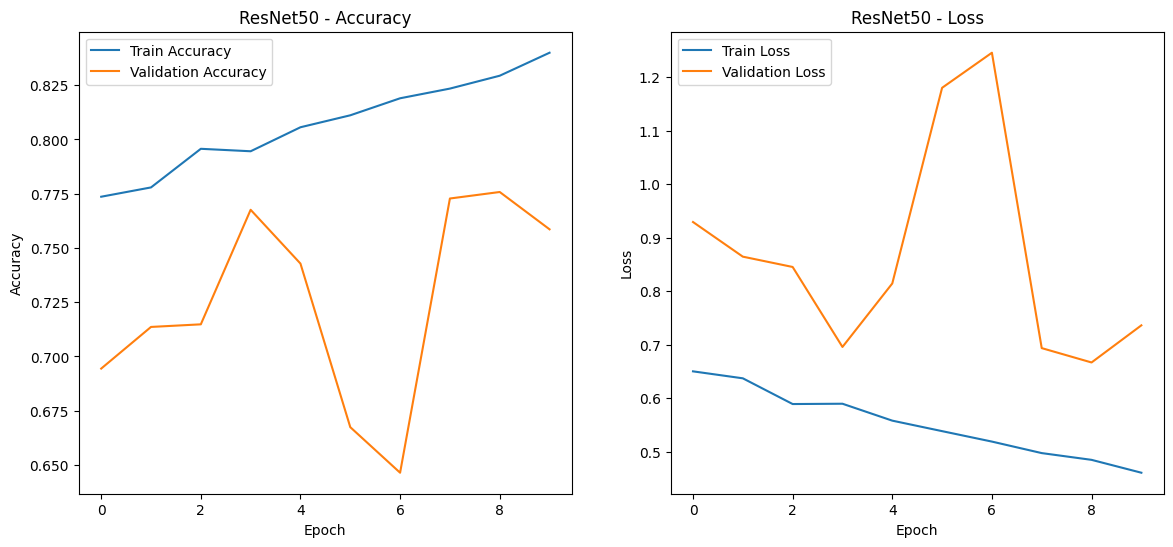

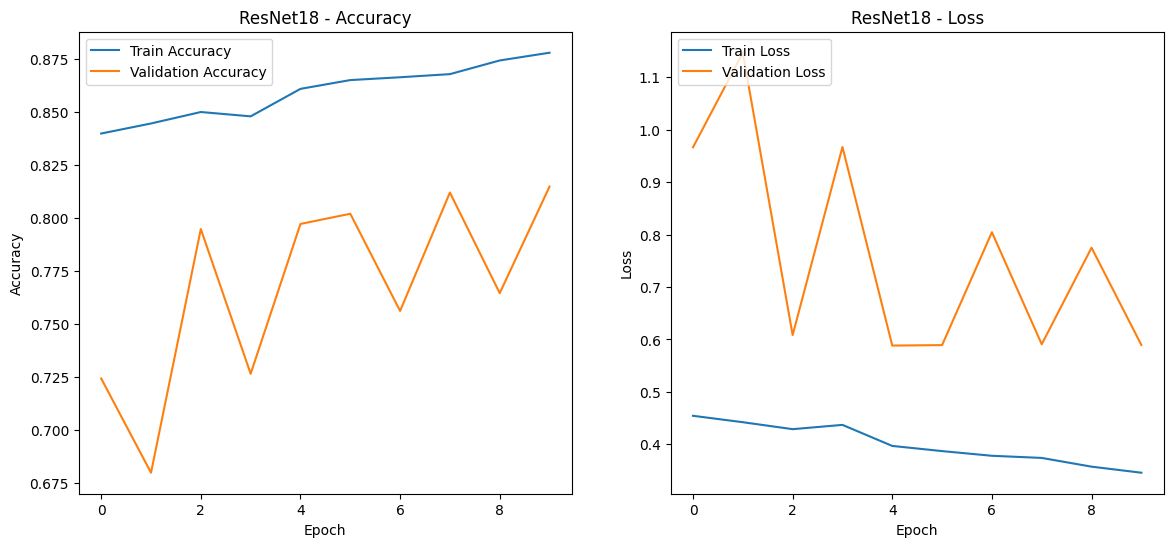

In [30]:
plt.figure(figsize=[14, 6])

plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('DenseNet121 - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_densenet.history['loss'], label='Train Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.title('DenseNet121 - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('DenseNet121_metrics.png')
plt.show()

plt.figure(figsize=[14, 6])

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('ResNet50_metrics.png')
plt.show()

plt.figure(figsize=[14, 6])

plt.subplot(1, 2, 1)
plt.plot(history_resnet18.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet18.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet18 - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet18.history['loss'], label='Train Loss')
plt.plot(history_resnet18.history['val_loss'], label='Validation Loss')
plt.title('ResNet18 - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('ResNet18_metrics.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
DenseNet121 - Predicted class: 3, True class: 3


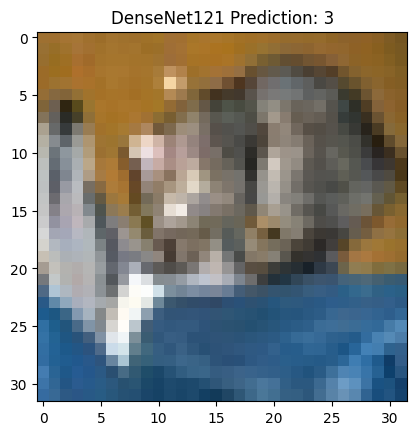

In [31]:
def predict_image(model, img_array):
    """Predict the class of a single image."""
    predicted_class = np.argmax(model.predict(img_array), axis=-1)
    return predicted_class

test_image = x_test[0:1]


predicted_class_densenet = predict_image(densenet_model, test_image)
print(f"DenseNet121 - Predicted class: {predicted_class_densenet[0]}, True class: {np.argmax(y_test[0])}")

plt.imshow(test_image[0])
plt.title(f'DenseNet121 Prediction: {predicted_class_densenet[0]}')
plt.savefig('test_image_prediction_densenet.png')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
ResNet50 - Predicted class: 3, True class: 3


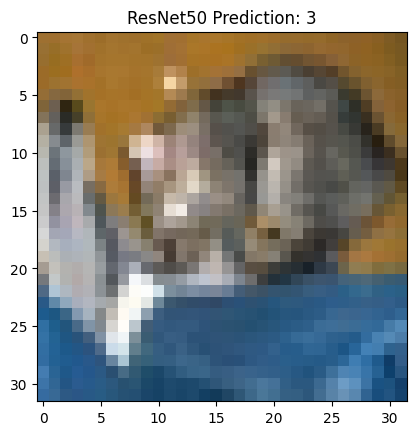

In [32]:
predicted_class_resnet = predict_image(resnet_model, test_image)
print(f"ResNet50 - Predicted class: {predicted_class_resnet[0]}, True class: {np.argmax(y_test[0])}")

plt.imshow(test_image[0])
plt.title(f'ResNet50 Prediction: {predicted_class_resnet[0]}')
plt.savefig('test_image_prediction_resnet.png')
plt.show()
